In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path, results_path
from preprocessing_modules import create_time_windows_with_labels, create_time_windows_with_metadata
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE
from tsai.models.ResNet import ResNet
from tsai.models import ResNet
from tsai.models.ResNet import ResNet
from fastai.metrics import accuracy
from fastai.data.core import DataLoaders
from fastai.learner import Learner
import csv

import torch
import wandb
wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")
from fastai.optimizer import SGD, Adam

/home/nwertheim/miniconda3/bin/python
/home/nwertheim/miniconda3/bin/python


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/nwertheim/.netrc
wandb: Currently logged in as: noorwertheim to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# Define FCMAE Hyperparameters (DON'T CHANGE):
batch_size = 16
num_blocks = 5
kernel_size = 7
base_dim = 32
learning_rate_FCMAE = 0.00016938000495408888
input_dimension = 512

# Specify hyperparameters (CHANGE) 
learning_rate = 3.3103174393377975e-07
optimizer_name = 'Adam' # or 'SGD'
data_subset = 60 # choose: 20, 40, 60, 80, 100

opt_func_map = {
'SGD': SGD,
'Adam': Adam,
}
opt_func = opt_func_map[optimizer_name]

Uncomment cel below if you want to save results

In [3]:
results_csv_path = os.path.join(results_path, "FCMAE_resnet_subset_runs.csv")

if not os.path.isfile(results_csv_path):
    with open(results_csv_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "run",
            "data_subset",
            "accuracy",
            "precision",
            "recall",
            "f1",
            "average_precision",
            "roc_auc"
        ])

In [4]:

'''MY DATA + class weights'''
train_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_train_2_" + str(data_subset) + ".npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_no_PCA_test_2.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import SGD
from torch.optim import AdamW
from functools import partial
from fastai.optimizer import OptimWrapper
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.core import DataLoaders



from collections import Counter

train_windows, train_labels, train_meta = create_time_windows_with_metadata(train_data)
test_windows, test_labels, test_meta = create_time_windows_with_metadata(test_data)

# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_windows_tensor = train_windows_tensor.unsqueeze(1)  # (1071, 1, 12000)
test_windows_tensor = test_windows_tensor.unsqueeze(1)    # (899, 1, 12000)

train_labels_tensor = train_labels_tensor.long()
test_labels_tensor = test_labels_tensor.long()


print(train_labels_tensor.shape)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Test metadata for reference
test_meta = test_meta
print('batch size', batch_size)
dls = DataLoaders(train_loader, test_loader)


# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

446
192
{'record_name': 'Hopper-2022_02_08_15_07_31-0000010181-0011-chan3', 'signal': array([[14.23043527],
       [24.57069717],
       [17.99612535],
       ...,
       [-1.21857878],
       [ 0.82743019],
       [-2.60873858]]), 'fs': 20, 'preterm': 1}
torch.Size([6324])
batch size 16


In [5]:



# Load the pre-trained encoder
path = os.path.join(models_path, 'FCMAE_encoder_no_PCA_gpu_normalized_correct.pth')


# Load the full FCMAE model
fcmae = FCMAE(in_channels=1, base_dim=base_dim, num_blocks=num_blocks, kernel_size=kernel_size)


# Load the saved weights into the full model
state_dict = torch.load(path)
fcmae.load_state_dict(state_dict)

# Extract only the encoder from the FCMAE model
encoder = fcmae.encoder
# Set the encoder to evaluation mode and freeze the encoder parameters
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False  # Freeze the encoder

print(encoder)

Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(2,), padding=(3,))
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv1d(256, 512, kernel_size=(7,), stride=(2,), padding=(3,))
  (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
)


In [7]:
import numpy as np
import torch
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, roc_auc_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from fastai.learner import Learner
from fastai.optimizer import SGD
from fastai.metrics import accuracy
from tsai.data.core import DataLoaders
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import SaveModelCallback, EarlyStoppingCallback


class FCMAEClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = ResNet(input_dimension, 2)  

    def forward(self, x):
        with torch.no_grad():  # freeze encoder
            x = self.encoder(x)
        return self.classifier(x)

# ----------------------------- Utility Functions -----------------------------
def seed_everything(seed):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ----------------------------- Experiment Setup -----------------------------
num_epochs = 10
num_runs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_train_losses = []
all_valid_losses = []
all_metrics = []

best_ap = -1
best_preds = None
best_targs = None

all_pred_labels = []
all_pred_probs = []

loss_func = torch.nn.CrossEntropyLoss(weight=class_weights_tensor) 

top_models = []  # List to store tuples of (AUC, model_state_dict, run_index)

for run in range(num_runs):
    print(f"\n🌀 Run {run+1}/{num_runs}")
    wandb.init(
        project=f"FCMAE-resnet-{data_subset}",
        name=f"resnet_{run+1}",
        config={
            "architecture": "FCMAE ResNet",
            "epochs": num_epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "run": run + 1
        }
    )

    seed_everything(run + 30)

    model = FCMAEClassifier(encoder).to(device)

    learn = Learner(
        dls,
        model,
        loss_func=loss_func,
        opt_func=opt_func,
        metrics=accuracy,
        cbs=[
            EarlyStoppingCallback(monitor='valid_loss', patience=3),
            SaveModelCallback(monitor='valid_loss', fname=f'best_fcmae_resnet_run_{run}'),
            WandbCallback(log='all', log_model=True, log_preds=True)
        ]
    )
    learn.model.to(device)

    # learn.fit_one_cycle(num_epochs, learning_rate, wd=1e-2)
    # no weight decay
    learn.fit_one_cycle(num_epochs, learning_rate)


    # Record losses
    losses = np.array(learn.recorder.losses)
    iters_per_epoch = len(dls.train)
    train_loss = losses[::2][:num_epochs]
    valid_loss = losses[1::2][:num_epochs]
    all_train_losses.append(train_loss)
    all_valid_losses.append(valid_loss)

    # Predictions
    preds, targs = learn.get_preds(dl=dls.valid)
    pred_labels = preds.argmax(dim=1)
    pred_probs = preds[:, 1].cpu().numpy()
    true_labels = targs.cpu().numpy()

    all_pred_labels.append(pred_labels.cpu().numpy())
    all_pred_probs.append(pred_probs)

    # Evaluation metrics
    acc = accuracy_score(true_labels, pred_labels)
    prec = precision_score(true_labels, pred_labels, zero_division=0)
    rec = recall_score(true_labels, pred_labels, zero_division=0)
    f1 = f1_score(true_labels, pred_labels, zero_division=0)
    ap = average_precision_score(true_labels, pred_probs)
    auc = roc_auc_score(true_labels, pred_probs)
    all_metrics.append([acc, prec, rec, f1, ap, auc])

    # # uncomment if you want to save results

    with open(results_csv_path, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([run + 1, data_subset, acc, prec, rec, f1, ap, auc])


    wandb.log({
        "final_accuracy": acc,
        "final_precision": prec,
        "final_recall": rec,
        "final_f1": f1,
        "final_average_precision": ap,
        "final_auc": auc
    })
    wandb.finish()

    if ap > best_ap:
        best_ap = ap
        best_preds = preds
        best_targs = true_labels
    
    
    # Track top models for saving
    top_models.append((auc, model.state_dict(), run))

# ----------------------------- Post-Processing -----------------------------
all_train_losses = np.stack(all_train_losses)
all_valid_losses = np.stack(all_valid_losses)
all_metrics = np.stack(all_metrics)

# Average + std metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AP', 'AUC']
mean_metrics = all_metrics.mean(axis=0)
std_metrics = all_metrics.std(axis=0)

print("\n📊 Final Evaluation:")
for name, mean, std in zip(metric_names, mean_metrics, std_metrics):
    print(f"{name}: {mean:.4f} ± {std:.4f}")

# Save predictions
pred_labels = best_preds.argmax(dim=1).cpu().numpy()
pred_probs = torch.softmax(best_preds, dim=1)[:, 1].cpu().numpy()

# Assuming `test_meta` has the record_name and window_index
window_ids = [entry['record_name'] + '-' + str(entry['window_index']) for entry in test_meta]
final_df = pd.DataFrame({
    'window_id': window_ids,
    'best_pred_label': pred_labels,
    'best_pred_prob': pred_probs,
    'target': best_targs
})

for run_idx, (labels, probs) in enumerate(zip(all_pred_labels, all_pred_probs), start=1):
    final_df[f'pred_label{run_idx}'] = labels
    final_df[f'pred_prob{run_idx}'] = probs

# Sort by AUC and keep top 5
top_models_sorted = sorted(top_models, key=lambda x: x[0], reverse=True)[:5]

# Save the top 5 models
for idx, (auc, state_dict, run_idx) in enumerate(top_models_sorted, start=1):
    save_path = f"top_model_100_{idx}_run_{run_idx+1}_auc_{auc:.4f}.pth"
    torch.save(state_dict, save_path)
    print(f"✅ Saved: {save_path}")


# # uncomment if you want to save results 
# final_df.to_csv("results_FCMAE_resnet_ADAM.csv", index=False)

# ----------------------------- Plot Loss Curves -----------------------------
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

mean_train = all_train_losses.mean(axis=0)
std_train = all_train_losses.std(axis=0)
plt.plot(epochs, mean_train, label='Train Loss')
plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, alpha=0.3)

mean_valid = all_valid_losses.mean(axis=0)
std_valid = all_valid_losses.std(axis=0)
plt.plot(epochs, mean_valid, label='Valid Loss')
plt.fill_between(epochs, mean_valid - std_valid, mean_valid + std_valid, alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Curves Over Five Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------- Plot Metrics -----------------------------
plt.figure(figsize=(10, 5))
plt.bar(metric_names, mean_metrics, yerr=std_metrics, capsize=5)
plt.title('Average Performance Over Five Runs')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ----------------------------- Confusion Matrix -----------------------------
cm = confusion_matrix(best_targs, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Best Performing Model Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



🌀 Run 1/30


accuracy,▅█▆▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▂▂▂▂▂▃▄▄▄▅▇▇█████████████▇▇▇▇▇▇▇▆▆▆
mom_0,████████▇▇▆▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃
raw_loss,▇▅▅▂▁▁▃▅▃▄█▂▄▂▂▂▃▆▃▂▄▁▄▂▄▂▄▃▃▂▃▄▃▅▂▃▄▂▄▃
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▆▆▆▅▅▆▆▄▅▄▃▄▄▄▄▄▃▃▁▂▂▁▂▂▂▂▁▁▁▁▂▂▂▂▂▂
train_samples_per_sec,███████████████████████████████▁████████
valid_loss,█▃▂▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.695808,0.645228,0.655729,00:04
1,0.691919,0.631286,0.655208,00:04
2,0.688954,0.626344,0.661458,00:04
3,0.687660,0.652171,0.659896,00:04
4,0.682599,0.658565,0.632812,00:04
5,0.681898,0.664772,0.620833,00:04


Better model found at epoch 0 with valid_loss value: 0.6452277898788452.
Better model found at epoch 1 with valid_loss value: 0.6312857866287231.
Better model found at epoch 2 with valid_loss value: 0.626343846321106.
No improvement since epoch 2: early stopping


accuracy,▇▇██▃▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▂▂▃▃▄▄▅▅▅▇▇▇▇▇████████████▇▇▇▇▇▇▇▆▆▆▅▅▅
mom_0,██████▇▇▇▇▆▄▄▃▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄



🌀 Run 2/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.738653,0.694574,0.447396,00:04
1,0.727418,0.675129,0.656771,00:04
2,0.709627,0.644997,0.787500,00:04
3,0.698589,0.627388,0.791146,00:04
4,0.696883,0.637996,0.786979,00:04
5,0.693483,0.622347,0.783333,00:04
6,0.680905,0.634481,0.751562,00:04
7,0.687894,0.620035,0.755208,00:04
8,0.687854,0.647210,0.745833,00:04
9,0.690090,0.640718,0.733854,00:04


Better model found at epoch 0 with valid_loss value: 0.6945739984512329.
Better model found at epoch 1 with valid_loss value: 0.675128698348999.
Better model found at epoch 2 with valid_loss value: 0.6449965834617615.
Better model found at epoch 3 with valid_loss value: 0.6273877024650574.
Better model found at epoch 5 with valid_loss value: 0.6223470568656921.
Better model found at epoch 7 with valid_loss value: 0.6200350522994995.


accuracy,▁▅████▇▇▇▇
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▂▂▃▃▅██████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁
mom_0,██▆▅▅▃▂▂▂▁▁▁▁▁▂▂▃▃▃▃▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██



🌀 Run 3/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.699584,0.695160,0.547917,00:04
1,0.690558,0.706173,0.408333,00:04
2,0.687598,0.677926,0.556250,00:04
3,0.684602,0.685878,0.532812,00:04
4,0.684198,0.681276,0.504167,00:04
5,0.683587,0.672609,0.527604,00:04
6,0.685877,0.672092,0.528125,00:04
7,0.674506,0.663058,0.640625,00:04
8,0.679762,0.703167,0.499479,00:04
9,0.680462,0.658379,0.631771,00:04


Better model found at epoch 0 with valid_loss value: 0.6951597332954407.
Better model found at epoch 2 with valid_loss value: 0.6779260635375977.
Better model found at epoch 5 with valid_loss value: 0.6726093888282776.
Better model found at epoch 6 with valid_loss value: 0.6720923185348511.
Better model found at epoch 7 with valid_loss value: 0.6630579829216003.
Better model found at epoch 9 with valid_loss value: 0.6583787798881531.


accuracy,▅▁▅▅▄▅▅█▄█
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▂▂▄▅▆▆▇▇█████▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁▁▁
mom_0,██▇▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▄▄▄▅▅▅▆▇▇▇████



🌀 Run 4/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.707553,0.724848,0.491667,00:04
1,0.720218,0.692041,0.480729,00:04
2,0.700015,0.673733,0.514063,00:04
3,0.693255,0.663988,0.576563,00:04
4,0.688370,0.654534,0.649479,00:04
5,0.682782,0.665245,0.647917,00:04
6,0.682561,0.657507,0.606250,00:04
7,0.685878,0.663443,0.536458,00:04


Better model found at epoch 0 with valid_loss value: 0.7248480319976807.
Better model found at epoch 1 with valid_loss value: 0.6920414566993713.
Better model found at epoch 2 with valid_loss value: 0.6737334728240967.
Better model found at epoch 3 with valid_loss value: 0.6639881134033203.
Better model found at epoch 4 with valid_loss value: 0.6545344591140747.
No improvement since epoch 4: early stopping


accuracy,▁▁▂▅██▆▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▁▂▃▃▄▆▇▇██████▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▃▂▂▂
mom_0,█▇▇▆▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▆▆▆▇



🌀 Run 5/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.738806,0.806065,0.212500,00:04
1,0.725940,0.813645,0.212500,00:04
2,0.715205,0.797847,0.212500,00:04
3,0.706913,0.796717,0.212500,00:04
4,0.697921,0.765931,0.278125,00:04
5,0.700740,0.769616,0.272917,00:04
6,0.695580,0.763278,0.283333,00:04
7,0.702403,0.786036,0.212500,00:04
8,0.704358,0.771411,0.265104,00:04
9,0.698269,0.763337,0.282292,00:04


Better model found at epoch 0 with valid_loss value: 0.8060654997825623.
Better model found at epoch 2 with valid_loss value: 0.797846794128418.
Better model found at epoch 3 with valid_loss value: 0.7967165112495422.
Better model found at epoch 4 with valid_loss value: 0.7659310698509216.
Better model found at epoch 6 with valid_loss value: 0.7632779479026794.
No improvement since epoch 6: early stopping


accuracy,▁▁▁▁▇▇█▁▆█
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▂▂▃▃▅▆▇▇▇█████████▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁▁
mom_0,███▇▅▄▃▃▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▅▆▆▆▇▇▇▇▇██████



🌀 Run 6/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.702016,0.639766,0.786979,00:04
1,0.699212,0.630903,0.786979,00:04
2,0.689253,0.629607,0.778125,00:04
3,0.692277,0.631036,0.773438,00:04
4,0.686819,0.630329,0.772917,00:04
5,0.682411,0.631235,0.736979,00:04


Better model found at epoch 0 with valid_loss value: 0.6397661566734314.
Better model found at epoch 1 with valid_loss value: 0.630902886390686.
Better model found at epoch 2 with valid_loss value: 0.6296066045761108.
No improvement since epoch 2: early stopping


accuracy,██▇▆▆▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇█
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▂▂▂▃▃▄▄▆▇▇▇▇▇▇██████████▇▇▇▇▇▇▇▇▇▆▆▆▆▅
mom_0,█████▇▇▇▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄



🌀 Run 7/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.697333,0.746676,0.356771,00:04
1,0.703772,0.749179,0.358333,00:04
2,0.699762,0.714044,0.485417,00:04
3,0.692275,0.710967,0.501562,00:04
4,0.695706,0.708303,0.484896,00:04
5,0.688495,0.713152,0.458854,00:04
6,0.689777,0.711344,0.456771,00:04
7,0.690579,0.716369,0.444792,00:04


Better model found at epoch 0 with valid_loss value: 0.7466761469841003.
Better model found at epoch 2 with valid_loss value: 0.7140439748764038.
Better model found at epoch 3 with valid_loss value: 0.7109671831130981.
Better model found at epoch 4 with valid_loss value: 0.708302915096283.
No improvement since epoch 4: early stopping


accuracy,▁▁▇█▇▆▆▅
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▂▂▂▃▄▅▅▆▆▆▇▇█████▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▂
mom_0,█▆▆▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇



🌀 Run 8/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.722052,0.822207,0.212500,00:04
1,0.708660,0.797915,0.212500,00:04
2,0.694882,0.785068,0.212500,00:04
3,0.702895,0.772026,0.212500,00:04
4,0.688536,0.781661,0.212500,00:04
5,0.694655,0.753352,0.310417,00:04
6,0.688892,0.759680,0.315104,00:04
7,0.689955,0.789747,0.212500,00:04
8,0.691483,0.754887,0.252083,00:04


Better model found at epoch 0 with valid_loss value: 0.8222067356109619.
Better model found at epoch 1 with valid_loss value: 0.7979145050048828.
Better model found at epoch 2 with valid_loss value: 0.7850682139396667.
Better model found at epoch 3 with valid_loss value: 0.7720258235931396.
Better model found at epoch 5 with valid_loss value: 0.7533522844314575.
No improvement since epoch 5: early stopping


accuracy,▁▁▁▁▁██▁▄
epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▂▃▄▅▅▆▆▇█████████▇▇▇▇▆▅▄▄▄▃▂▂▂▂▂▂▁▁▁▁
mom_0,██▇▆▆▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▅▅▅▆▆▆▆▆▆▇▇████



🌀 Run 9/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.721696,0.676629,0.620833,00:04
1,0.701925,0.659372,0.785937,00:04
2,0.695186,0.635455,0.781771,00:04
3,0.690713,0.636784,0.783333,00:04
4,0.692010,0.622021,0.781771,00:04
5,0.691050,0.625832,0.776563,00:04
6,0.688599,0.624324,0.779688,00:04
7,0.683874,0.627057,0.784896,00:04


Better model found at epoch 0 with valid_loss value: 0.6766294836997986.
Better model found at epoch 1 with valid_loss value: 0.6593716740608215.
Better model found at epoch 2 with valid_loss value: 0.6354551911354065.
Better model found at epoch 4 with valid_loss value: 0.6220207810401917.
No improvement since epoch 4: early stopping


accuracy,▁███████
epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▁▁▂▂▂▃▄▅▇████████▇▇▇▆▆▅▅▅▅▅▅▄▄▃▃▃▃▃▂▂
mom_0,█▇▇▇▇▄▄▃▃▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▇



🌀 Run 10/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.704648,0.671762,0.768750,00:04
1,0.696732,0.674977,0.738542,00:04
2,0.693179,0.656358,0.766146,00:04
3,0.687846,0.652201,0.765625,00:04
4,0.687975,0.683521,0.629167,00:04
5,0.687389,0.646871,0.758854,00:04
6,0.683536,0.654470,0.732292,00:04
7,0.684306,0.652341,0.734375,00:04
8,0.673123,0.662030,0.724479,00:04


Better model found at epoch 0 with valid_loss value: 0.6717621684074402.
Better model found at epoch 2 with valid_loss value: 0.6563581824302673.
Better model found at epoch 3 with valid_loss value: 0.6522012948989868.
Better model found at epoch 5 with valid_loss value: 0.6468708515167236.
No improvement since epoch 5: early stopping


accuracy,█▆██▁█▆▆▆
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▂▂▂▄▆█████████▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▁▁
mom_0,████▇▆▆▆▄▂▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇██



🌀 Run 11/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.725772,0.831829,0.212500,00:04
1,0.718903,0.823953,0.212500,00:04
2,0.716829,0.834817,0.212500,00:04
3,0.706895,0.776006,0.212500,00:04
4,0.694890,0.770556,0.212500,00:04
5,0.696116,0.754520,0.240104,00:04
6,0.695770,0.751378,0.263542,00:04
7,0.704864,0.782848,0.212500,00:04
8,0.703261,0.748134,0.291667,00:04
9,0.695823,0.741496,0.286458,00:04


Better model found at epoch 0 with valid_loss value: 0.831828773021698.
Better model found at epoch 1 with valid_loss value: 0.8239530324935913.
Better model found at epoch 3 with valid_loss value: 0.7760055065155029.
Better model found at epoch 4 with valid_loss value: 0.7705561518669128.
Better model found at epoch 5 with valid_loss value: 0.7545201778411865.
Better model found at epoch 6 with valid_loss value: 0.7513784766197205.
Better model found at epoch 8 with valid_loss value: 0.7481343746185303.
Better model found at epoch 9 with valid_loss value: 0.7414960861206055.


accuracy,▁▁▁▁▁▃▆▁██
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▂▂▃▆▇▇██████▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▃▃▂▂▂▂▁▁▁▁
mom_0,██▆▆▃▂▂▂▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▆▆▇▇▇▇▇█████



🌀 Run 12/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.700836,0.743848,0.235417,00:04
1,0.700278,0.732659,0.225000,00:04
2,0.695714,0.721446,0.288021,00:04
3,0.688536,0.708132,0.470833,00:04
4,0.692184,0.696379,0.584375,00:04
5,0.689261,0.699634,0.517187,00:04
6,0.687820,0.706208,0.496354,00:04
7,0.687380,0.697510,0.571354,00:04


Better model found at epoch 0 with valid_loss value: 0.7438481450080872.
Better model found at epoch 1 with valid_loss value: 0.7326592206954956.
Better model found at epoch 2 with valid_loss value: 0.7214460968971252.
Better model found at epoch 3 with valid_loss value: 0.7081322073936462.
Better model found at epoch 4 with valid_loss value: 0.6963786482810974.
No improvement since epoch 4: early stopping


accuracy,▁▁▂▆█▇▆█
epoch,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▃▄▅▅▅▆▆▇▇█████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂
mom_0,████▇▄▃▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▇



🌀 Run 13/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.701853,0.769341,0.224479,00:04
1,0.693877,0.753982,0.221875,00:04
2,0.689397,0.741051,0.292708,00:04
3,0.689530,0.764623,0.218750,00:04
4,0.688137,0.724843,0.311458,00:04
5,0.685571,0.729627,0.298438,00:04
6,0.686712,0.736216,0.288021,00:04
7,0.685157,0.737090,0.474479,00:04


Better model found at epoch 0 with valid_loss value: 0.7693409323692322.
Better model found at epoch 1 with valid_loss value: 0.7539823055267334.
Better model found at epoch 2 with valid_loss value: 0.741051435470581.
Better model found at epoch 4 with valid_loss value: 0.7248433232307434.
No improvement since epoch 4: early stopping


accuracy,▁▁▃▁▄▃▃█
epoch,▁▁▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▃▃▄▆▇▇▇██████████▇▇▇▇▇▇▇▇▇▇▆▆▅▅▄▃▂▂▂▂
mom_0,██▇▆▄▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▅▆▆▆▆▇▇▇



🌀 Run 14/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.702472,0.701113,0.375521,00:04
1,0.696499,0.683280,0.556771,00:04
2,0.692944,0.666090,0.655729,00:04
3,0.696554,0.665980,0.646875,00:04
4,0.685962,0.659530,0.643750,00:04
5,0.683226,0.656124,0.646354,00:04
6,0.687136,0.650632,0.652083,00:04
7,0.681494,0.660617,0.637500,00:04
8,0.685166,0.655652,0.651563,00:04
9,0.687901,0.670538,0.529167,00:04


Better model found at epoch 0 with valid_loss value: 0.701112687587738.
Better model found at epoch 1 with valid_loss value: 0.6832797527313232.
Better model found at epoch 2 with valid_loss value: 0.6660898327827454.
Better model found at epoch 3 with valid_loss value: 0.6659796237945557.
Better model found at epoch 4 with valid_loss value: 0.6595298647880554.
Better model found at epoch 5 with valid_loss value: 0.6561242341995239.
Better model found at epoch 6 with valid_loss value: 0.6506324410438538.
No improvement since epoch 6: early stopping


accuracy,▁▆███████▅
epoch,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▂▃▅▆▇▇▇█████▇▇▇▇▆▅▅▄▄▄▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁
mom_0,█▇▅▅▂▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▅▆▆▆▆▆▆▇▇▇▇▇▇███



🌀 Run 15/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.698439,0.710029,0.247396,00:04
1,0.695224,0.700220,0.397917,00:04
2,0.690570,0.696022,0.500000,00:04
3,0.687455,0.685867,0.611979,00:04
4,0.686552,0.693294,0.594271,00:04
5,0.684653,0.698779,0.505729,00:04
6,0.685859,0.676392,0.563542,00:04
7,0.685092,0.680182,0.642708,00:04
8,0.682774,0.692705,0.521354,00:04
9,0.683312,0.697670,0.515104,00:04


Better model found at epoch 0 with valid_loss value: 0.7100285291671753.
Better model found at epoch 1 with valid_loss value: 0.7002201080322266.
Better model found at epoch 2 with valid_loss value: 0.6960216760635376.
Better model found at epoch 3 with valid_loss value: 0.6858670115470886.
Better model found at epoch 6 with valid_loss value: 0.6763924360275269.
No improvement since epoch 6: early stopping


accuracy,▁▄▅▇▇▆▇█▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▂▂▃▄▅▆▆▇▇████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁
mom_0,█▇▇▂▂▁▁▁▁▁▂▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▆▆▇▇▇▇███████



🌀 Run 16/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.701738,0.648018,0.785937,00:04
1,0.705440,0.639471,0.786458,00:04
2,0.693775,0.636965,0.784375,00:04
3,0.689763,0.629851,0.758854,00:04
4,0.685643,0.634867,0.736979,00:04
5,0.687665,0.639857,0.682292,00:04
6,0.684923,0.655281,0.578646,00:04


Better model found at epoch 0 with valid_loss value: 0.648017942905426.
Better model found at epoch 1 with valid_loss value: 0.639470636844635.
Better model found at epoch 2 with valid_loss value: 0.6369650959968567.
Better model found at epoch 3 with valid_loss value: 0.6298511624336243.
No improvement since epoch 3: early stopping


accuracy,███▇▆▄▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▂▂▂▃▃▄▄▅▅▅▆▇▇█████████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▃
mom_0,██▇▇▇▅▃▃▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅



🌀 Run 17/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.707983,0.687287,0.494792,00:04
1,0.703544,0.673995,0.682292,00:04
2,0.694640,0.662530,0.747917,00:04
3,0.687498,0.675764,0.522917,00:04
4,0.686892,0.677836,0.511979,00:04
5,0.688423,0.665183,0.622917,00:04


Better model found at epoch 0 with valid_loss value: 0.6872871518135071.
Better model found at epoch 1 with valid_loss value: 0.6739946007728577.
Better model found at epoch 2 with valid_loss value: 0.6625297665596008.
No improvement since epoch 2: early stopping


accuracy,▁▆█▂▁▅
epoch,▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▂▂▃▃▃▃▄▅▆▆▇▇██████████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅
mom_0,████▇▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄



🌀 Run 18/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.704593,0.771233,0.324479,00:04
1,0.696571,0.748009,0.259896,00:04
2,0.693675,0.725772,0.265104,00:04
3,0.689780,0.712212,0.310937,00:04
4,0.685675,0.707821,0.374479,00:04
5,0.684246,0.708580,0.340104,00:04
6,0.685404,0.705224,0.364062,00:04
7,0.681582,0.715931,0.386458,00:04
8,0.688656,0.721038,0.294271,00:04
9,0.684048,0.709991,0.473958,00:04


Better model found at epoch 0 with valid_loss value: 0.7712329626083374.
Better model found at epoch 1 with valid_loss value: 0.7480089068412781.
Better model found at epoch 2 with valid_loss value: 0.725771963596344.
Better model found at epoch 3 with valid_loss value: 0.7122122049331665.
Better model found at epoch 4 with valid_loss value: 0.7078207731246948.
Better model found at epoch 6 with valid_loss value: 0.7052240371704102.
No improvement since epoch 6: early stopping


accuracy,▃▁▁▃▅▄▄▅▂█
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▂▃▃▆▇█████████▇▇▇▇▇▇▆▆▆▆▅▄▄▄▄▄▃▃▂▂▁▁▁▁
mom_0,█████▇▆▃▂▂▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▆▆▇▇▇▇▇██████



🌀 Run 19/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.730689,0.771416,0.282813,00:04
1,0.725628,0.844825,0.232292,00:04
2,0.731231,0.817520,0.212500,00:04
3,0.704532,0.814091,0.212500,00:04


Better model found at epoch 0 with valid_loss value: 0.7714162468910217.
No improvement since epoch 0: early stopping


accuracy,█▃▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_accuracy,▁
final_auc,▁
final_average_precision,▁
final_f1,▁
final_precision,▁
final_recall,▁
lr_0,▁▁▁▁▁▂▂▃▃▆▆▆▆▆▇▇▇▇█████████████████████▇
mom_0,████▇▇▇▇▇▆▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂



🌀 Run 20/30


Could not gather input dimensions
WandbCallback was not able to prepare a DataLoader for logging prediction samples -> 'TensorDataset' object has no attribute 'items'


epoch,train_loss,valid_loss,accuracy,time
0,0.703789,0.764780,0.529167,00:04
1,0.701355,0.762778,0.220313,00:04


Better model found at epoch 0 with valid_loss value: 0.7647801041603088.
Better model found at epoch 1 with valid_loss value: 0.7627777457237244.


KeyboardInterrupt: 

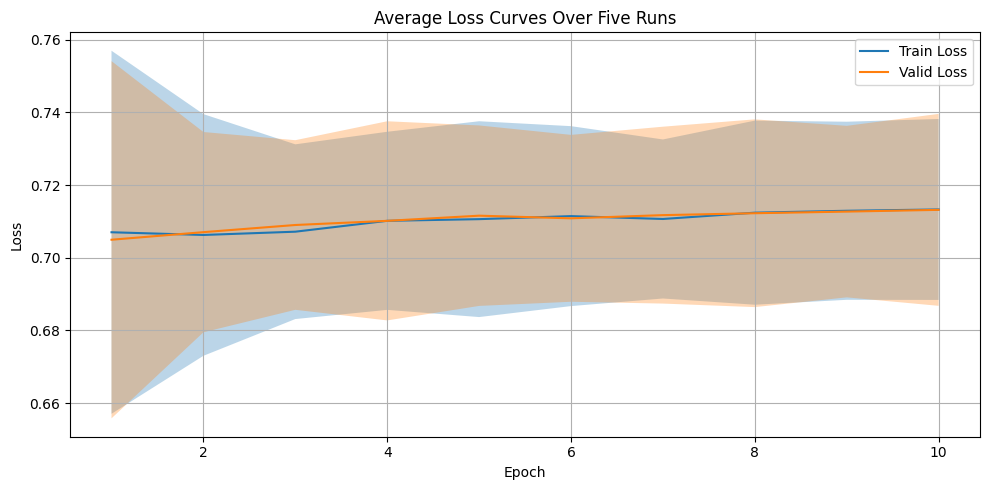

In [13]:
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

mean_train = all_train_losses.mean(axis=0)
std_train = all_train_losses.std(axis=0)
plt.plot(epochs, mean_train, label='Train Loss')
plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, alpha=0.3)

mean_valid = all_valid_losses.mean(axis=0)
std_valid = all_valid_losses.std(axis=0)
plt.plot(epochs, mean_valid, label='Valid Loss')
plt.fill_between(epochs, mean_valid - std_valid, mean_valid + std_valid, alpha=0.3)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Average Loss Curves Over Five Runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
class FCMAEClassifier(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.classifier = ResNet(input_dimension, 2)  

    def forward(self, x):
        with torch.no_grad():  # freeze encoder
            x = self.encoder(x)
        return self.classifier(x)

best_model = os.path.join('models', 'best_fcmae_resnet_run_15.pth')
# best_model = os.path.join('models')

model = FCMAEClassifier(encoder)  # use the same encoder structure
model.load_state_dict(torch.load(best_model))
model.eval()



FCMAEClassifier(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(32, 64, kernel_size=(7,), stride=(2,), padding=(3,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 128, kernel_size=(7,), stride=(2,), padding=(3,))
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(128, 256, kernel_size=(7,), stride=(2,), padding=(3,))
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(256, 512, kernel_size=(7,), stride=(2,), padding=(3,))
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (classifier): ResNet(
    (resblock1): ResBlock(
      (convblock1): C